# 2019 Pass Catcher & Runner Uniformity

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text

import requests
import csaps

import team_colors


sns.set(style="whitegrid", 
        palette="pastel", 
        font='Circular Spotify Text', 
        font_scale = 1.1, 
        rc= {'grid.color': '.95', 'xtick.color': '.3', 'ytick.color': '.3'})


## Data

In [2]:
year = 2019

df = pd.read_csv("../data/nflscrapR/reg_pbp_{}.csv".format(year), low_memory=False)

In [3]:
#Adding week data to main dataframe

try:
    response_reg = requests.get('http://www.nfl.com/feeds-rs/schedules/{}.json'.format(year)).json()
except requests.exceptions.RequestException as e:
    print(e)

schedules = pd.DataFrame.from_dict(response_reg['gameSchedules'])
schedules = schedules.loc[schedules['seasonType'] == 'REG', ['gameId', 'week']]

schedules = schedules.rename(columns={'gameId' : 'game_id'})

df = df.merge(schedules, how='left', on=['game_id'])

In [4]:
plays = df.loc[(df['play_type'].isin(['pass','run'])) & (df['epa'].notna()) & (df['posteam'].notna())]

In [5]:
plays.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,week
1,50,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
2,71,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
3,95,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
6,195,2019090500,CHI,GB,CHI,home,GB,CHI,52.0,2019-09-05,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
7,216,2019090500,CHI,GB,CHI,home,GB,GB,47.0,2019-09-05,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1


In [6]:
list(df.columns)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

## Getting the top x pass catchers per team

In [7]:
rec_ranks = (plays.loc[(plays['play_type'] == 'pass') & (plays['complete_pass'] == 1),]
 .groupby(['posteam', 'receiver_player_name'])
 .agg({'epa' : 'sum'})
 .reset_index()
 .sort_values(['posteam', 'epa'], ascending=[True, False])
)

In [8]:
rec_ranks['team_rank'] = rec_ranks.groupby('posteam').cumcount() + 1
rec_ranks.head()

,posteam,receiver_player_name,epa,team_rank
6,ARI,L.Fitzgerald,23.575834,1
2,ARI,C.Kirk,18.910257,2
4,ARI,D.Johnson,8.918333,3
3,ARI,D.Byrd,7.404597,4
5,ARI,K.Johnson,7.098095,5


In [9]:
ranks = rec_ranks.loc[rec_ranks['team_rank'] <= 6]
ranks.head()

,posteam,receiver_player_name,epa,team_rank
6,ARI,L.Fitzgerald,23.575834,1
2,ARI,C.Kirk,18.910257,2
4,ARI,D.Johnson,8.918333,3
3,ARI,D.Byrd,7.404597,4
5,ARI,K.Johnson,7.098095,5


In [10]:
ranks = ranks.pivot(index='posteam', columns='team_rank', values='epa')
ranks

team_rank,1,2,3,4,5,6
posteam,,,,,,
ARI,23.575834,18.910257,8.918333,7.404597,7.098095,4.040712
ATL,37.812268,25.278170,20.678799,16.517044,3.184146,3.032692
BAL,27.044333,22.822814,12.802749,7.862486,7.848712,6.675070
BUF,28.240196,17.576021,8.293710,5.626774,4.649704,4.453024
CAR,19.837268,16.754126,16.417352,15.809418,6.305031,2.161545
CHI,23.726070,10.415497,6.468479,5.143964,4.272529,3.762835
CIN,22.426347,18.457641,5.238527,4.132964,3.618635,3.478659
CLE,21.989802,16.011646,12.669132,9.807931,4.833348,4.066257
DAL,30.310502,17.029568,13.380843,11.942197,9.391214,7.136869


In [11]:
vectors = ranks.div(ranks.sum(axis=1), axis=0)
vectors.head()

team_rank,1,2,3,4,5,6
posteam,,,,,,
ARI,0.337049,0.270348,0.127500,0.105859,0.101477,0.057768
ATL,0.355034,0.237347,0.194161,0.155085,0.029897,0.028475
BAL,0.317959,0.268326,0.150521,0.092439,0.092277,0.078478
BUF,0.410233,0.255319,0.120479,0.081738,0.067544,0.064687
CAR,0.256678,0.216784,0.212427,0.204561,0.081582,0.027969


In [12]:
# (norm(m(i,:))*sqrt(d)-1) / (sqrt(d)-1)
# From here! https://stats.stackexchange.com/questions/25827/how-does-one-measure-the-non-uniformity-of-a-distribution

def norm_func(x, d):
    return (((la.norm(x)*np.sqrt(d))-1) / (np.sqrt(d)-1))
    

In [13]:
vectors['norm'] = vectors.iloc[:, :6].apply(lambda x: 1 - norm_func(x, len(vectors.columns)), axis=1)
vectors.head()

team_rank,1,2,3,4,5,6,norm
posteam,,,,,,,
ARI,0.337049,0.270348,0.127500,0.105859,0.101477,0.057768,0.883360
ATL,0.355034,0.237347,0.194161,0.155085,0.029897,0.028475,0.852013
BAL,0.317959,0.268326,0.150521,0.092439,0.092277,0.078478,0.899119
BUF,0.410233,0.255319,0.120479,0.081738,0.067544,0.064687,0.822564
CAR,0.256678,0.216784,0.212427,0.204561,0.081582,0.027969,0.920508


### Get EPA per play now, ya hear

In [14]:
data = pd.merge(vectors, plays[plays['play_type'] == 'pass'].groupby('posteam').agg({'epa' : 'mean'}).sort_values('epa', ascending=False), on='posteam', how='left')

In [15]:
data = data.reset_index()

## Charts!

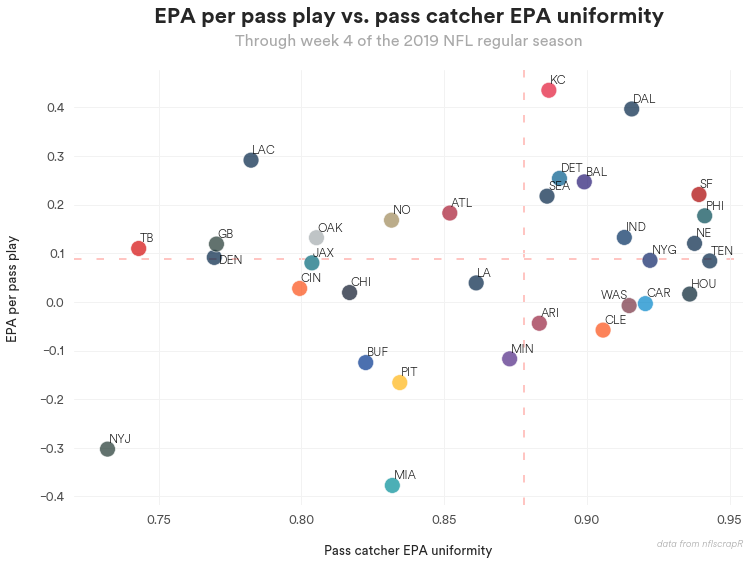

In [16]:
f, ax = plt.subplots(figsize=(12, 8))

week = np.max(df['week'])

# Plotting all other teams and adding names

plt.axhline(np.median(data['epa']), linestyle=(0, (5, 10)), color='r', alpha=0.8, lw=1.5, zorder=-1)
plt.axvline(np.median(data['norm']), linestyle=(0, (5, 10)), color='r', alpha=0.8, lw=1.5, zorder=-1)

ax = sns.scatterplot(x="norm", 
                     y="epa",
                     hue="posteam", 
                     palette=team_colors.get_colors(),
                     data=data,
                     legend=False,
                     alpha=0.7,
                     s=250
                    )

ax.text(x=0.5, 
        y=1.1, 
        s='EPA per pass play vs. pass catcher EPA uniformity', 
        fontsize=22,
        weight='bold', 
        ha='center', 
        va='bottom', 
        transform=ax.transAxes)

ax.text(x=0.5, 
        y=1.05, 
        s='Through week {} of the {} NFL regular season'.format(week, year), 
        fontsize=16, 
        color='darkgray', 
        ha='center', 
        va='bottom', 
        transform=ax.transAxes)

ax.text(x=1, 
        y=-0.1, 
        s='data from nflscrapR', 
        fontsize=10,
        weight='light',
        style='italic',
        color='darkgray', 
        ha='right', 
        va='bottom', 
        transform=ax.transAxes)
        
texts = [plt.text(data['norm'][line], data['epa'][line], data['posteam'][line], horizontalalignment='left', size=12, color='black', weight='light', alpha=0.9) for line in range(0,data.shape[0])]

ax.set_ylabel('EPA per pass play\n')
ax.set_xlabel('\nPass catcher EPA uniformity')



#texts.append(plt.text(data[data['posteam'] == 'SF']['return_yards'].values[0], data[data['posteam'] == 'SF']['epa'].values[0], data[data['posteam'] == 'SF']['posteam'].values[0], horizontalalignment='left', size=20, color='black', weight='semibold'))
adjust_text(texts, force_points=(2, 4), force_text=(1, 2.5))

#plt.xlim(reversed(plt.xlim()))    

sns.despine(left=True, right=True, top=True, bottom=True)
plt.savefig('output/norms/' + 'epa_vs_pass_catcher_uniformity_{}.png'.format(year), format='png', dpi=300, bbox_inches='tight')

Idea! Make the uniformity metric based on EPA for both pass and run plays

In [ ]:
rec_ranks.loc[rec_ranks['posteam'] == 'GB']